# Static Plots

- [pandas.DataFrame.plot — pandas 1.4.1 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib — Visualization with Python](https://matplotlib.org/)
- [seaborn: statistical data visualization — seaborn 0.11.2 documentation](https://seaborn.pydata.org/)
- [Chart Visualization — pandas 1.4.2 documentation](https://pandas.pydata.org/docs/user_guide/visualization.html)



## 約定データ
- [crypto-chassis/cryptochassis-data-api-docs: A REST API providing snapshot, tick, and aggregated market data for crypto-currencies](https://github.com/crypto-chassis/cryptochassis-data-api-docs#trade)


In [2]:
import os
import sys
import datetime
import requests
import gzip
import pandas as pd

In [32]:
def download_zip(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [31]:
def get_data_url(url):
    r = requests.get(url)
    if r.status_code == 200:
        if r.json()["urls"]:
            return r.json()["urls"][0]["url"]
    return None
def trade_link(endpoint, exchange, instrument, starttime):
    """
    starttime: YYYY-mm-dd
    """
    base_url = f"/trade/{exchange}/{instrument}?startTime={starttime}"
    return endpoint + base_url


def gz_path(exchange, instrument, date, save_dir):
    return os.path.join(f"{save_dir}", f"{exchange}_{instrument}_{date}.gz")


def get_execution_gz(endpoint, exchange, instrument, date, save_dir, download_anyway):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    gzpath = gz_path(exchange, instrument, date, save_dir)
    if os.path.exists(gzpath) and not download_anyway:
        print(
            f"{gzpath} exits. Since download_anyway option is False, Will not Download"
        )
        return

    cryptochassis_trade_api_url = trade_link(endpoint, exchange, instrument, date)
    gz_url = get_data_url(cryptochassis_trade_api_url)

    print(f"DOWNLOADING {endpoint}, {exchange}, {instrument}, {date} TO {gzpath}")
    download_zip(gz_url, gzpath)


def gz_to_dataframe(gzfile):
    with open(gzfile, "rb") as fd:
        gzip_fd = gzip.GzipFile(fileobj=fd)
        df = pd.read_csv(gzip_fd)
        instrument = os.path.basename(gzfile).split("_")[1]
        df["instrument"] = instrument
        df["datetime"] = pd.to_datetime(df["time_seconds"], unit="s", utc=True)
        df = df.set_index("datetime")
        df = df.drop_duplicates()

    return df

In [34]:
endpoint = "https://api.cryptochassis.com/v1"
exchange = "binance"
instruments = ["eth-eur", "btc-eur"]
date = "2022-04-02"
# save_dir = "./data/binance/gz"
save_dir = "/tmp/binance/gz"
download_anyway = True

for instrument in instruments:
    get_execution_gz(endpoint, exchange, instrument, date, save_dir, download_anyway)




DOWNLOADING https://api.cryptochassis.com/v1, binance, eth-eur, 2022-04-02 TO /tmp/binance/gz/binance_eth-eur_2022-04-02.gz


In [61]:
df_eth_eur =gz_to_dataframe("/tmp/binance/gz/binance_eth-eur_2022-04-02.gz")
df_btc_eur =gz_to_dataframe("/tmp/binance/gz/binance_btc-eur_2022-04-02.gz")



In [36]:
df_btc_eur.head()

,time_seconds,price,size,is_buyer_maker,instrument
datetime,,,,,
2022-04-02 00:00:02.060000+00:00,1.648858e+09,41966.26,0.00046,0,btc-eur
2022-04-02 00:00:02.112999936+00:00,1.648858e+09,41965.00,0.00763,1,btc-eur
2022-04-02 00:00:02.732999936+00:00,1.648858e+09,41965.45,0.09207,0,btc-eur
2022-04-02 00:00:08.733999872+00:00,1.648858e+09,41963.78,0.01548,1,btc-eur
2022-04-02 00:00:09.201999872+00:00,1.648858e+09,41965.03,0.00036,1,btc-eur


In [37]:
df_btc_eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45882 entries, 2022-04-02 00:00:02.060000+00:00 to 2022-04-02 23:59:55.856000+00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_seconds    45882 non-null  float64
 1   price           45882 non-null  float64
 2   size            45882 non-null  float64
 3   is_buyer_maker  45882 non-null  int64  
 4   instrument      45882 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ MB


## plot

### df.plot() のオプションを使い倒す
- 

- 時系列の折れ線グラフ
- 価格帯別出来高
- ボリュームの(棒)グラフを下につける
- 指標は代表的なやつを1つ紹介する(SMA, RSIなど)

In [64]:
df_ohlc_btc_eur = df_btc_eur["price"].resample("1s", label="right").ohlc()
df_ohlc_btc_eur["volume"] = df_btc_eur["size"].resample("1s", label="right").sum()

df_ohlc_eth_eur = df_eth_eur["price"].resample("1s", label="right").ohlc()
df_ohlc_eth_eur["volume"] = df_eth_eur["size"].resample("1s", label="right").sum()



In [65]:
df_ohlc_btc_eur.head()

,open,high,low,close,volume
datetime,,,,,
2022-04-02 00:00:03+00:00,41966.26,41966.26,41965.0,41965.45,0.10016
2022-04-02 00:00:04+00:00,NaN,NaN,NaN,NaN,0.00000
2022-04-02 00:00:05+00:00,NaN,NaN,NaN,NaN,0.00000
2022-04-02 00:00:06+00:00,NaN,NaN,NaN,NaN,0.00000
2022-04-02 00:00:07+00:00,NaN,NaN,NaN,NaN,0.00000


### 折れ線グラフ


<AxesSubplot:xlabel='datetime'>

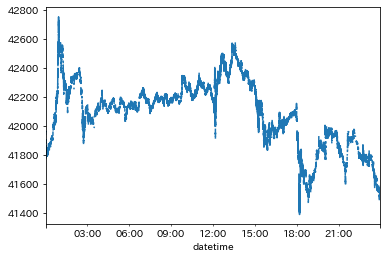

In [66]:
df_ohlc_btc_eur["close"].plot()

<AxesSubplot:title={'center':'Close'}, xlabel='datetime'>

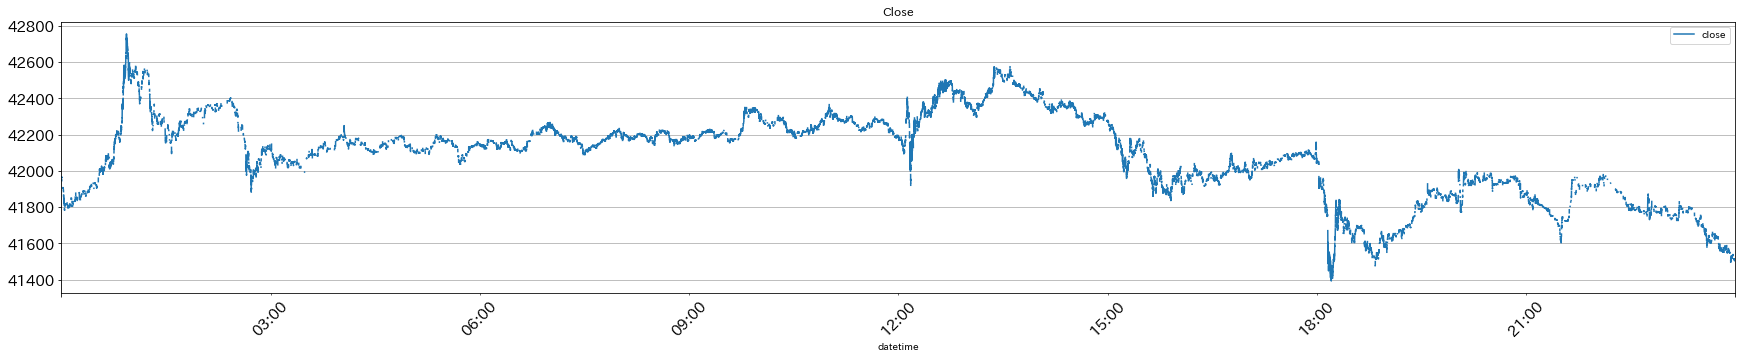

In [67]:
df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="Close", legend=True, rot=45, fontsize=15)

In [183]:
import ta
df_ohlc_btc_eur["RSI14min"] = ta.momentum.rsi(df_ohlc_btc_eur["close"], window=14*60)

array([[<AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>]], dtype=object)

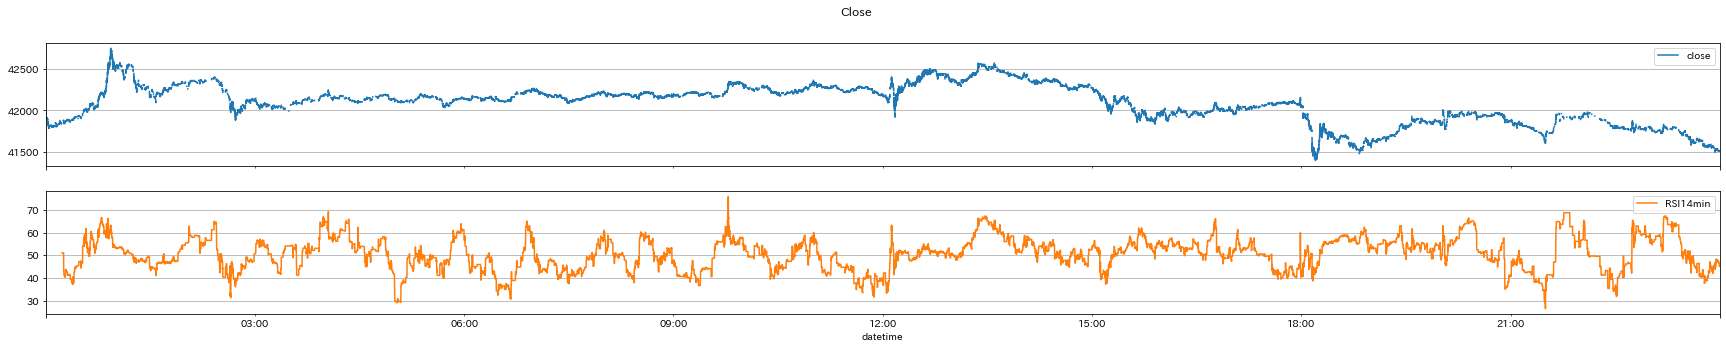

In [185]:
df_ohlc_btc_eur[["close", "RSI14min"]].plot(grid=True, figsize=(30,5), title="Close", legend=True, subplots=True, layout=(2,1))

<AxesSubplot:xlabel='datetime'>

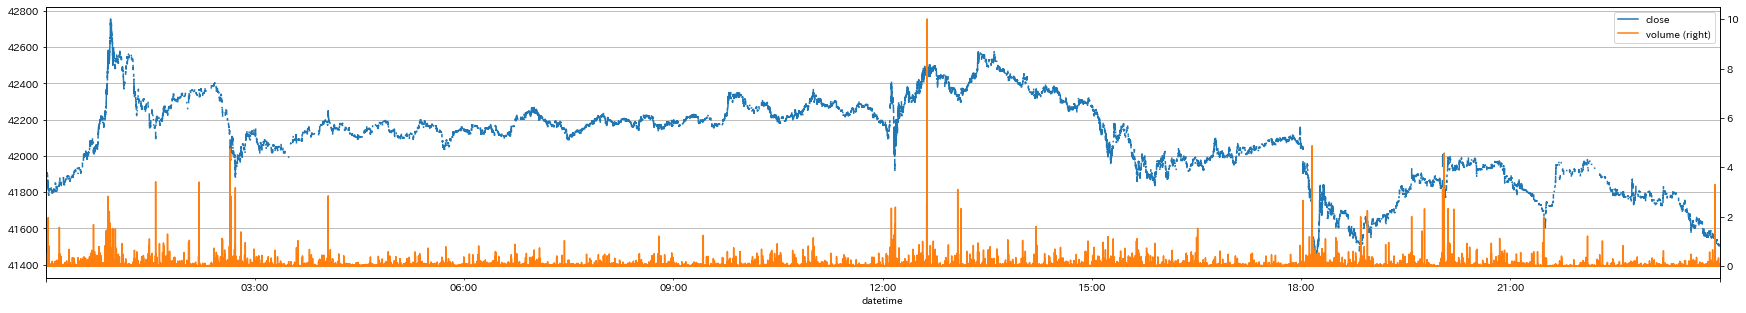

In [187]:
df_ohlc_btc_eur[["close", "volume"]].plot(secondary_y="volume", figsize=(30,5),grid=True)

<AxesSubplot:xlabel='datetime'>

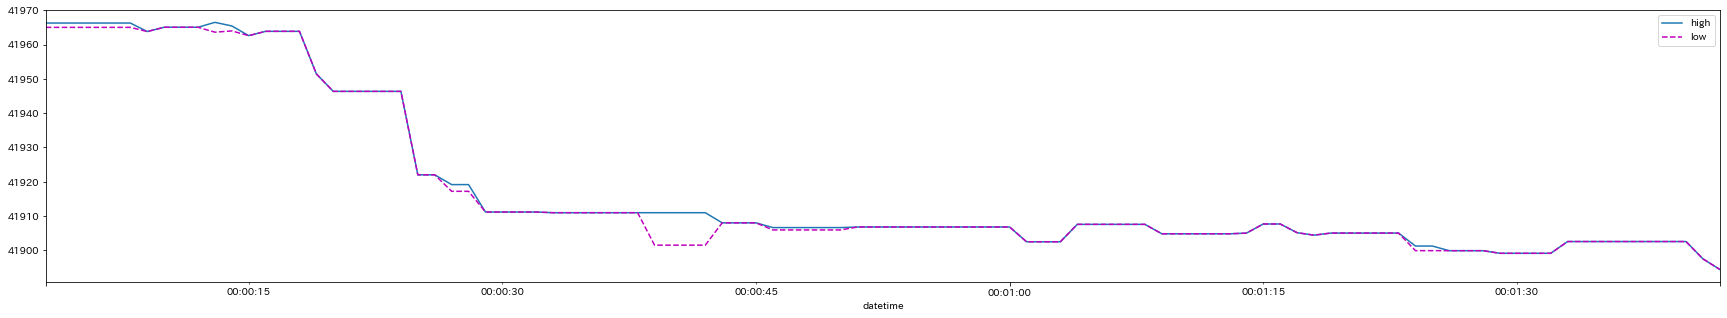

In [70]:
df_ohlc_btc_eur[["high", "low"]].fillna(method="ffill").head(100).plot(figsize=(30,5), style={"low": "m--"},)


<AxesSubplot:title={'center':'Close'}, xlabel='時間', ylabel='価格'>

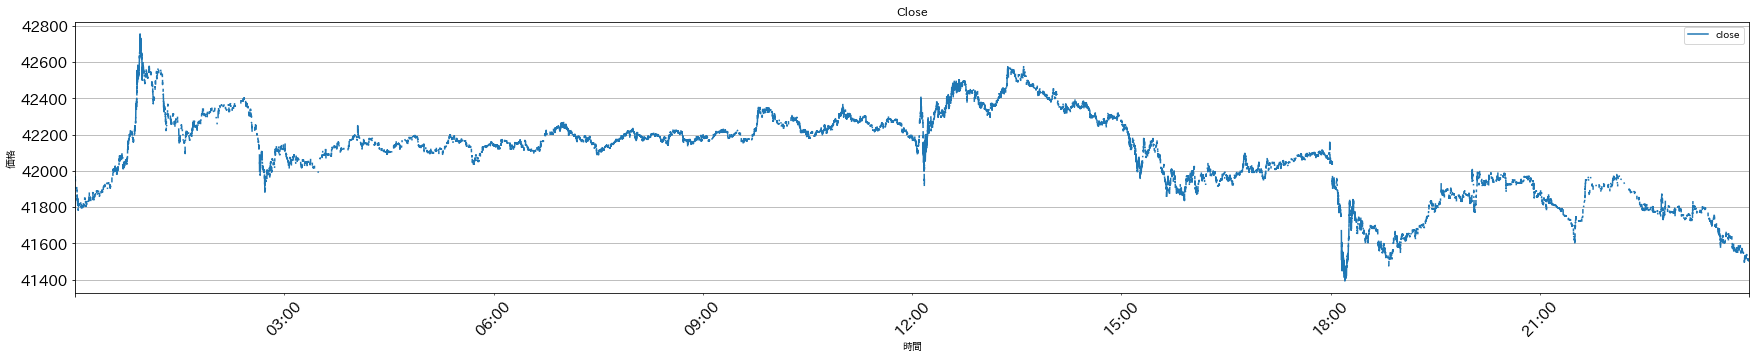

In [71]:
import japanize_matplotlib

df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="Close", legend=True, rot=45, fontsize=15, xlabel="時間", ylabel="価格")


<AxesSubplot:xlabel='datetime'>

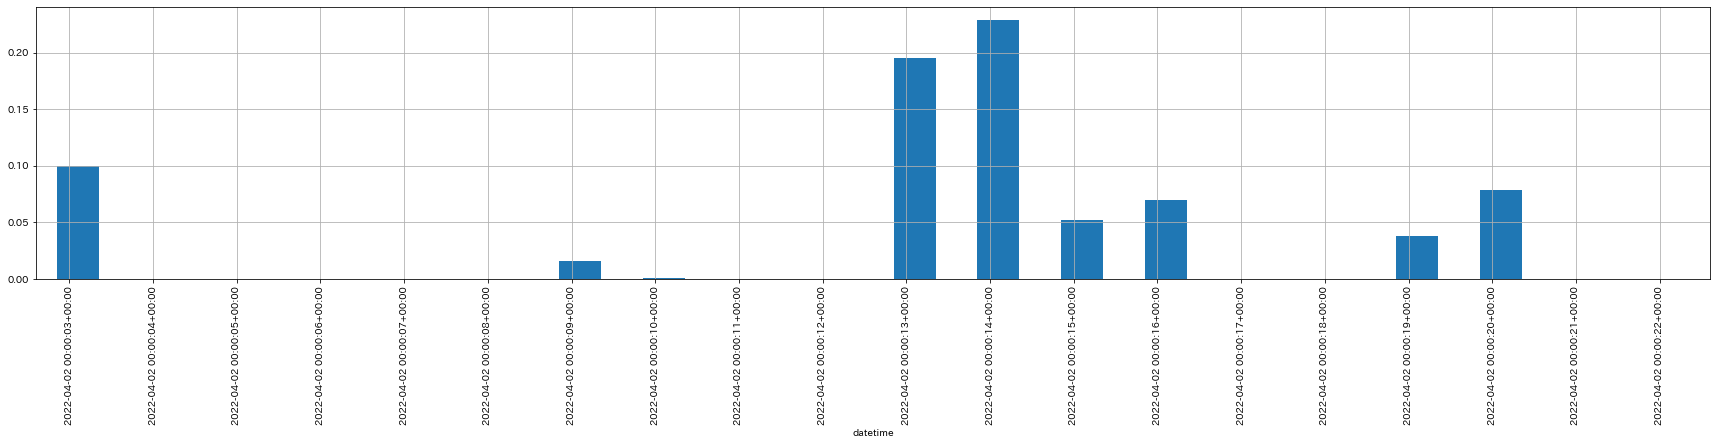

In [72]:
df_ohlc_btc_eur["volume"].head(20).plot(kind="bar", grid=True, figsize=(30,5), position=0.3)

In [73]:
df_min = df_ohlc_btc_eur[["close"]].resample("1min", label="right").last()
df_min["change"] = df_min["close"].pct_change()
df_min


,close,change
datetime,,
2022-04-02 00:01:00+00:00,41906.77,NaN
2022-04-02 00:02:00+00:00,41850.10,-0.001352
2022-04-02 00:03:00+00:00,41814.72,-0.000845
2022-04-02 00:04:00+00:00,41814.35,-0.000009
2022-04-02 00:05:00+00:00,41823.02,0.000207
...,...,...
2022-04-02 23:56:00+00:00,41514.85,-0.000858
2022-04-02 23:57:00+00:00,41526.42,0.000279
2022-04-02 23:58:00+00:00,41537.50,0.000267


<AxesSubplot:ylabel='Frequency'>

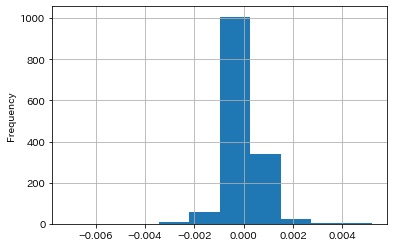

In [74]:
df_min["change"].plot(kind="hist", grid=True)

<AxesSubplot:ylabel='Frequency'>

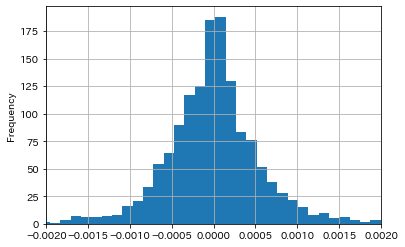

In [75]:
df_min["change"].plot(kind="hist", grid=True, bins=100, xlim=(-0.002, 0.002))

<AxesSubplot:ylabel='Density'>

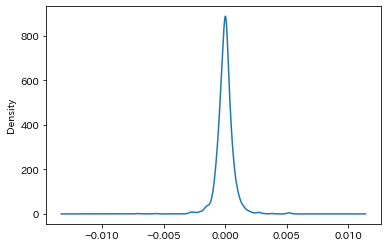

In [76]:
df_min["change"].plot(kind="kde",)

In [79]:
df_1 = pd.DataFrame({
    "BTCEUR": df_ohlc_btc_eur["close"], 
    "ETHEUR": df_ohlc_eth_eur["close"], 
    })

<AxesSubplot:xlabel='BTCEUR', ylabel='ETHEUR'>

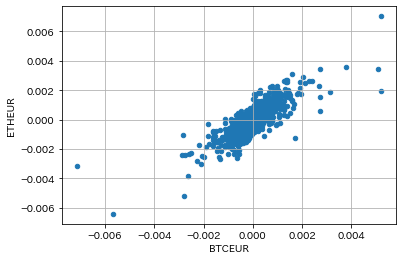

In [94]:
df_1.resample("1min", label="right").last().pct_change().plot(kind="scatter", x="BTCEUR", y="ETHEUR", grid=True)

<AxesSubplot:xlabel='datetime'>

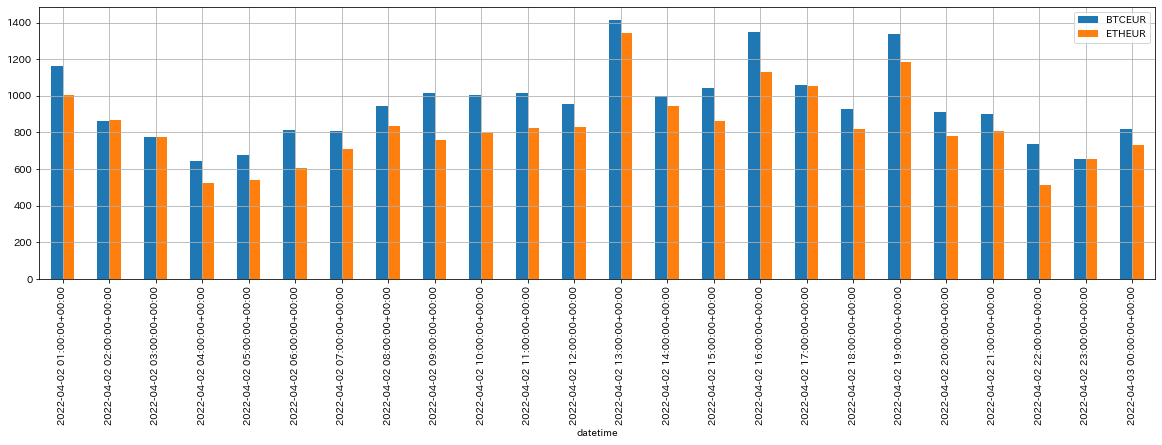

In [99]:
df_1.resample("1H", label="right").count().plot(kind="bar", grid=True, figsize=(20,5))

matplotlibのstyleを変える - Qiita
https://qiita.com/eriksoon/items/b93030ba4dc686ecfbba

[Style sheets reference — Matplotlib 3.5.1 documentation](https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html)




## 価格帯別出来高


In [176]:
df_15min = df_btc_eur["price"].resample("15min", label="right").ohlc()
df_15min["volume"] = df_btc_eur["size"].resample("15min", label="right").sum()
df_15min["pricecut"] = pd.cut(df_15min["close"], 30, ).apply(lambda x: x.left)
s_vol_by_price = df_15min.groupby("pricecut")["volume"].sum()

<AxesSubplot:ylabel='pricecut'>

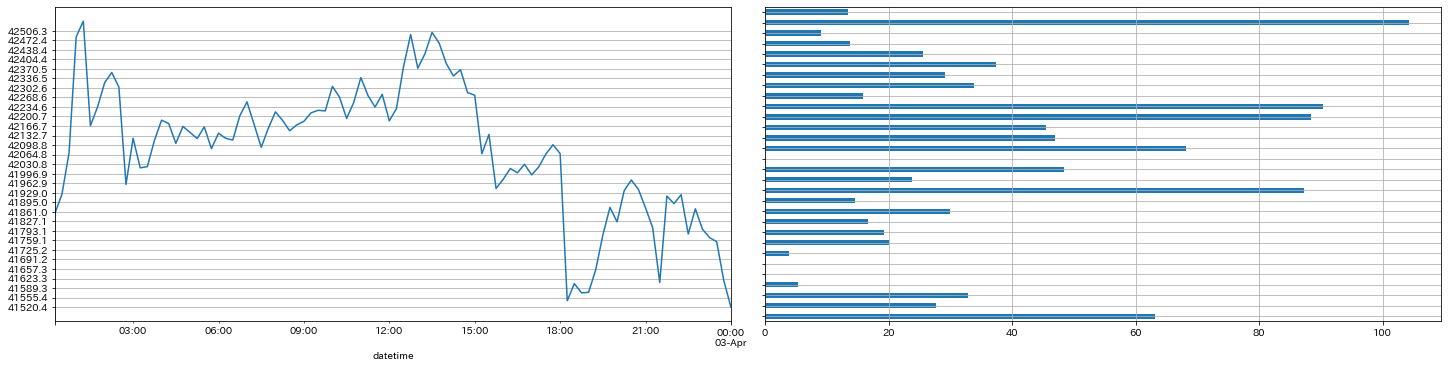

In [177]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 5), constrained_layout = True)
df_15min["close"].plot(ax=axes[0], yticks=s_vol_by_price.index, grid=True)
s_vol_by_price.plot(kind="barh",ax=axes[1],sharey=axes[0], grid=True)
